In [1]:
# Show plots as part of the notebook (this is a Jupyter-specific operation)
%matplotlib inline
import time
import matplotlib.pyplot as plt
import requests
import xmltodict
# Standard library packages
import os

# Import Pandas and Seaborn
import pandas as pd
import seaborn as sns
import numpy as np

# Import Biopython tools for running local BLASTX
from Bio.Blast.Applications import NcbiblastxCommandline
from Bio.Blast.Applications import NcbiblastnCommandline

#For execution time tracking
from datetime import datetime
from pytz import timezone

In [2]:
now_time = datetime.now(timezone('America/Chicago'))
print(now_time.strftime('%I:%M:%S %p'))

11:27:44 AM


In [4]:
%%time
df = pd.read_csv('01_db_blastn_July142020_filtered_1e-20_95perc-id_subj.csv')

CPU times: user 1.07 s, sys: 99.6 ms, total: 1.17 s
Wall time: 1.17 s


In [5]:
df['subject'].nunique()

9092

In [6]:
df = df['subject'].value_counts()
df = pd.Series(df)
df

JAGRRH010000013.1    16532
NC_008588.1           5973
MN937452.1            5926
NC_014287.1           5916
MW645084.1            5905
                     ...  
KX013963.1               1
KX013970.1               1
KX013976.1               1
KX013979.1               1
GL433848.1               1
Name: subject, Length: 9092, dtype: int64

In [7]:
df.to_csv('01_1_July142020_filtered_1e-20_95perc-id_subj_to_7level_taxonomy.csv')

In [8]:
df = pd.read_csv('01_1_July142020_filtered_1e-20_95perc-id_subj_to_7level_taxonomy.csv')

In [9]:
df.head()

,Unnamed: 0,subject
0,JAGRRH010000013.1,16532
1,NC_008588.1,5973
2,MN937452.1,5926
3,NC_014287.1,5916
4,MW645084.1,5905


In [10]:
df.columns.values[0] = "subject"
df.columns.values[1] = "count"

In [11]:
df.to_csv('01_1_July142020_filtered_1e-20_95perc-id_subj_to_7level_taxonomy.csv', index= False)

In [12]:
df = pd.read_csv('01_1_July142020_filtered_1e-20_95perc-id_subj_to_7level_taxonomy.csv')

In [13]:
df.head()

,subject,count
0,JAGRRH010000013.1,16532
1,NC_008588.1,5973
2,MN937452.1,5926
3,NC_014287.1,5916
4,MW645084.1,5905


## Retrieving (efetch) taxonomy heirarchy from NCBI

In [14]:
base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/{}"
db = "nuccore"

In [15]:
def get_taxon_name(tax_id):
    try:
        efetch = "efetch.fcgi?db={}&id={}&rettype=json".format(db, tax_id)
        efetch_response = requests.get(base_url.format(efetch))
        efetch_dict = xmltodict.parse(efetch_response.content)
        Definition = efetch_dict['GBSet']['GBSeq']['GBSeq_definition']
        Definition = Definition.split(',')
        Definition = Definition[0]
        time.sleep(0.5)
    except:
        Definition = tax_id
        pass
 
    return Definition

In [16]:
get_taxon_name ('NC_016703.1')

'Phaeocystis antarctica plastid'

In [17]:
def get_7level_taxonomy(tax_id):
    try:   
        efetch = "efetch.fcgi?db={}&id={}&rettype=json".format(db, tax_id)
        efetch_response = requests.get(base_url.format(efetch))
        efetch_dict = xmltodict.parse(efetch_response.content)
        GBSeq_taxonomy = efetch_dict['GBSet']['GBSeq']['GBSeq_taxonomy']
#        GBSeq_taxonomy_class = GBSeq_taxonomy.split("; ")
#        GBSeq_taxonomy_class = GBSeq_taxonomy_class[2]
        time.sleep(0.5)
    except:
        GBSeq_taxonomy = tax_id
        pass
    
    return GBSeq_taxonomy

In [18]:
get_7level_taxonomy ('NC_016703.1')

'Eukaryota; Haptophyceae; Phaeocystales; Phaeocystaceae; Phaeocystis'

In [19]:
df.head()

,subject,count
0,JAGRRH010000013.1,16532
1,NC_008588.1,5973
2,MN937452.1,5926
3,NC_014287.1,5916
4,MW645084.1,5905


In [20]:
df['subject']

0       JAGRRH010000013.1
1             NC_008588.1
2              MN937452.1
3             NC_014287.1
4              MW645084.1
              ...        
9087           KX013963.1
9088           KX013970.1
9089           KX013976.1
9090           KX013979.1
9091           GL433848.1
Name: subject, Length: 9092, dtype: object

In [21]:
%%time
def enrich_dataset(df):
    taxon_value = df['subject']
    Seven_Level_Taxonomy = get_7level_taxonomy(taxon_value)
    df['7Level_Taxonomy'] = Seven_Level_Taxonomy
    return df

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 16 µs


In [22]:
%%time
df = df.apply(enrich_dataset, axis=1)

CPU times: user 5min 42s, sys: 43.6 s, total: 6min 26s
Wall time: 3h 5min 43s


In [23]:
df.to_csv('04_July142020_filtered_1e-20_95perc-id_subj_to_7level_taxonomy_enriched.csv', index= False)

# Process Taxonomic Levels, Extract Information

In [24]:
df = pd.read_csv('04_July142020_filtered_1e-20_95perc-id_subj_to_7level_taxonomy_enriched.csv')

In [25]:
df['7Level_Taxonomy'].nunique()

2703

In [26]:
df.head(5)

,subject,count,7Level_Taxonomy
0,JAGRRH010000013.1,16532,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...
1,NC_008588.1,5973,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...
2,MN937452.1,5926,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...
3,NC_014287.1,5916,Eukaryota; Sar; Alveolata; Dinophyceae; Peridi...
4,MW645084.1,5905,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...


In [27]:
def taxlevel (tax):
    tax = tax.split("; ")
    tax_len = len(tax)
    
    return tax_len

In [28]:
def enrich_dataset(df):
    taxon_level = df['7Level_Taxonomy']
    Seven_Level_Taxonomy = taxlevel(taxon_level)
    df['7Level_Lenght'] = Seven_Level_Taxonomy
    return df

In [29]:
%%time
df = df.apply(enrich_dataset, axis=1)

CPU times: user 1.25 s, sys: 8.38 ms, total: 1.26 s
Wall time: 1.26 s


In [30]:
df.head()

,subject,count,7Level_Taxonomy,7Level_Lenght
0,JAGRRH010000013.1,16532,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...,10
1,NC_008588.1,5973,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...,10
2,MN937452.1,5926,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...,10
3,NC_014287.1,5916,Eukaryota; Sar; Alveolata; Dinophyceae; Peridi...,7
4,MW645084.1,5905,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...,10


In [31]:
df['7Level_Lenght'].value_counts()

1     2000
2     1690
6     1583
9      880
4      680
8      650
7      492
10     418
5      266
3      236
11     197
Name: 7Level_Lenght, dtype: int64

In [32]:
df.shape

(9092, 4)

In [33]:
df["Levels"] = df["7Level_Lenght"].replace({11: "11_Levels",
                                           10: "10_Levels",
                                           9: "9_Levels",
                                           8: "8_Levels",
                                           7: "7_Levels",
                                           6: "6_Levels",
                                           5: "5_Levels",
                                           4: "4_Levels",
                                           3: "3_Levels",
                                           2: "2_Levels",
                                           1: "1_Level",
                                           })

In [34]:
df.head()

,subject,count,7Level_Taxonomy,7Level_Lenght,Levels
0,JAGRRH010000013.1,16532,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...,10,10_Levels
1,NC_008588.1,5973,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...,10,10_Levels
2,MN937452.1,5926,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...,10,10_Levels
3,NC_014287.1,5916,Eukaryota; Sar; Alveolata; Dinophyceae; Peridi...,7,7_Levels
4,MW645084.1,5905,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...,10,10_Levels


<AxesSubplot:>

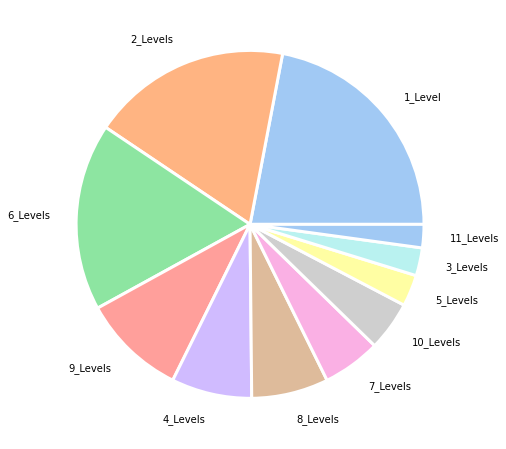

In [35]:
plt.rcParams["figure.figsize"] = (30,8)
colors = sns.color_palette('pastel')[0:11]
df['Levels'].value_counts().plot.pie(labeldistance=1.15, 
                                     wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, 
                                     colors=colors,
                                     ylabel='')

<AxesSubplot:>

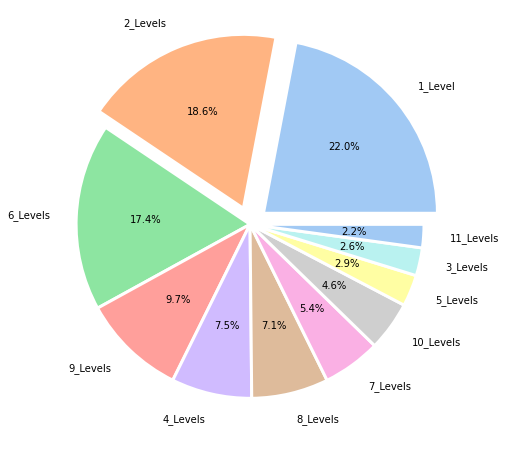

In [36]:
plt.rcParams["figure.figsize"] = (30,8)
colors = sns.color_palette('pastel')[0:11]
explode = (0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0)
df['Levels'].value_counts().plot.pie(labeldistance=1.15, 
                                     wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, 
                                     colors=colors,
                                     ylabel='',
                                     autopct='%1.1f%%',
                                     explode = explode)

<AxesSubplot:>

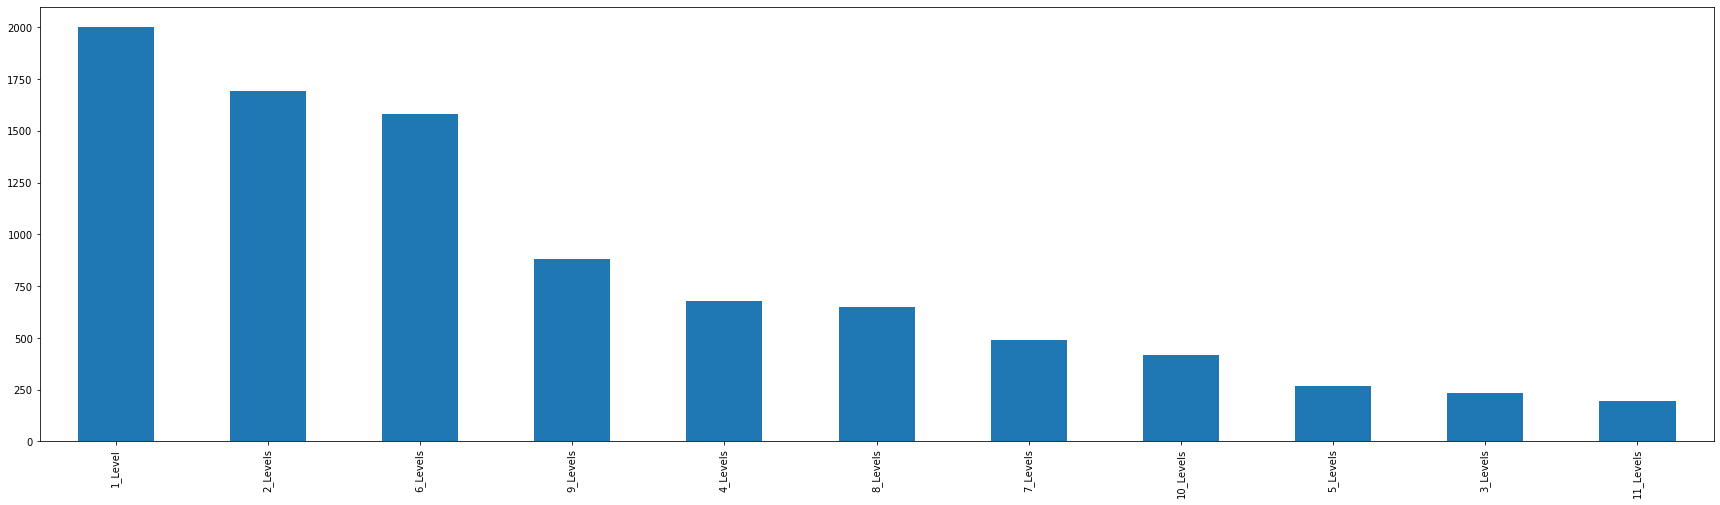

In [37]:
df['Levels'].value_counts().plot.bar()

##### Saving the count of taxonomic levels of each subject (blasted accession numbers from Nucleotide database of NCBI)

In [38]:
df.to_csv('05_July142020_filtered_1e-20_95perc-id_subj_to_7level_taxonomy_enriched.csv', index= False)